<a href="https://colab.research.google.com/github/kunalburgul/MLDS_Learning/blob/master/Pytorch/GANs/cgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Generating Spoofed Face Images Using Coditional - Generative Adversarial Network (CGAN)**

## **Dataset**



**During the training of the CGAN:** 

The Generator is parameterized to learn and produce realistic samples for each label in the training dataset.
The Discriminator learns to distinguish fake and real samples, given the label information. 
However, their  roles don’t change. The Generator and Discriminator continue  to generate and classify images, but with conditional auxiliary information.


In [ ]:
#import the required packages
import os
import cv2
import torch
import numpy as np
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

## **Getting the Data**

Downloading the dataset from the link:

In [ ]:
!gdown --id 1rfbp8Fb6yknCfpsd5P1pRU5_1hO_3XBq --output /content/face_data.zip

Downloading...
From: https://drive.google.com/uc?id=1rfbp8Fb6yknCfpsd5P1pRU5_1hO_3XBq
To: /content/face_data.zip
136MB [00:02, 51.9MB/s]


Once we are done with the downloading now lets extract the data in the data folder.

In [ ]:
%%capture
!unzip /content/face_data.zip -d /content/data/

In [ ]:
# !rm -R /content/data/

In [ ]:
# Path to the data directory
DATA_DIR = './data'
print(os.listdir(DATA_DIR))

['enroll-cropped-data']


Applying the transformations to the dataset.

In [ ]:
# Transformation for the images
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets
import torchvision.transforms as T

data_dir = DATA_DIR + '/enroll-cropped-data'
image_size = 128
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

trsfm = T.Compose([T.Resize(image_size),
                   T.CenterCrop(image_size),
                   T.ToTensor(), 
                   T.Normalize(*stats)])

traindataset = datasets.ImageFolder(data_dir, transform=trsfm)

- Begin by downloading the dataset from the source website.
- Once downloaded, use the ImageFolder module to load the dataset.
- Apply a total of three transformations: Resizing the image to 128 dimensions, converting the images to Torch tensors, and normalizing the pixel values in the range [-1, 1].
- Finally, prepare the training dataloader by feeding the training dataset, batch_size, and shuffle as True. You will recall that to train the CGAN, we need both images and labels. Ensure that our training dataloader has both.

In [ ]:
print(traindataset.classes)

['1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


In [ ]:
train_dl = DataLoader(traindataset, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=4, 
                      pin_memory=True)

Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
# Plotting the training data images
from torchvision.utils import make_grid

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

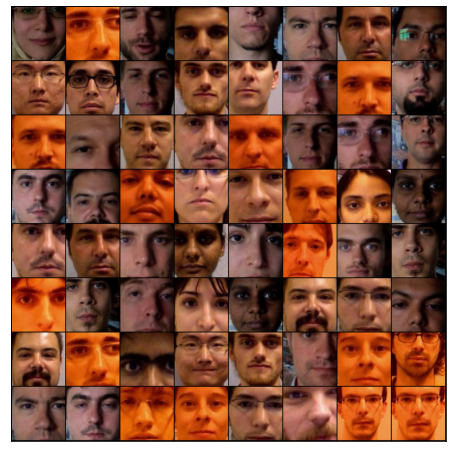

In [ ]:
show_batch(train_dl)

For multi-gpu extecution we need the following ...

In [ ]:
import torch.nn.parallel

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


## **Generator**

In [ ]:
import torch.nn as nn

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
     
        self.label_conditioned_generator = nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                                                         nn.Linear(embedding_dim, 16))
        
    
        self.latent = nn.Sequential(nn.Linear(latent_dim, 4*4*512),
                                    nn.LeakyReLU(0.2, inplace=True))
           

        self.model = nn.Sequential(nn.ConvTranspose2d(513, 64*8, 4, 2, 1, bias=False),
                                   nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                                   nn.ReLU(True),
                                   nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1,bias=False),
                                   nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                                   nn.ReLU(True), 
                                   nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1,bias=False),
                                   nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                                   nn.ReLU(True), 
                                   nn.ConvTranspose2d(64*2, 64*1, 4, 2, 1,bias=False),
                                   nn.BatchNorm2d(64*1, momentum=0.1,  eps=0.8),
                                   nn.ReLU(True), 
                                   nn.ConvTranspose2d(64*1, 3, 4, 2, 1, bias=False),
                                   nn.Tanh())

    def forward(self, inputs):
        noise_vector, label = inputs
        label_output = self.label_conditioned_generator(label)
        label_output = label_output.view(-1, 1, 4, 4)
        latent_output = self.latent(noise_vector)
        latent_output = latent_output.view(-1, 512,4,4)
        concat = torch.cat((latent_output, label_output), dim=1)
        image = self.model(concat)
        #print(image.size())
        return image

- **con_label** – This is simply a (1,) vector, which expects one of three class labels as an input. 
- **latent_vector** –  This is the usual noise vector input that we have in other GAN networks. In this case, it is a (100,) vector.

In [ ]:
def label_conditioned_generator(n_classes=3, embedding_dim=100):
    # embedding for categorical input
    label_embedding = nn.Embedding(n_classes, embedding_dim)(con_label)
    #print(label_embedding)
    # linear multiplication
    nodes = 4 * 4 
    label_dense = layers.Dense(nodes)(label_embedding)
    # reshape to additional channel
    label_reshape_layer = layers.Reshape((4, 4, 1))(label_dense)
    return label_reshape_layer

def latent_input(latent_dim=100):
    # image generator input
    nodes = 512 * 4 * 4
    latent_dense = layers.Dense(nodes)(latent_vector)
    latent_dense = layers.ReLU()(latent_dense)
    latent_reshape = layers.Reshape((4, 4, 512))(latent_dense)
    return latent_reshape

In [ ]:
train_ds = ImageFolder(data_dir, 
                       transform=T.Compose([T.Resize(image_size),
                                                      T.CenterCrop(image_size),
                                                      T.ToTensor(),
                                                      T.Normalize(*stats)]))
train_ds

NameError: ignored

In [ ]:
train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=4, 
                      pin_memory=True)

For multi-gpu extecution we need the following ...

Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
# Plotting the training data images
from torchvision.utils import make_grid

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

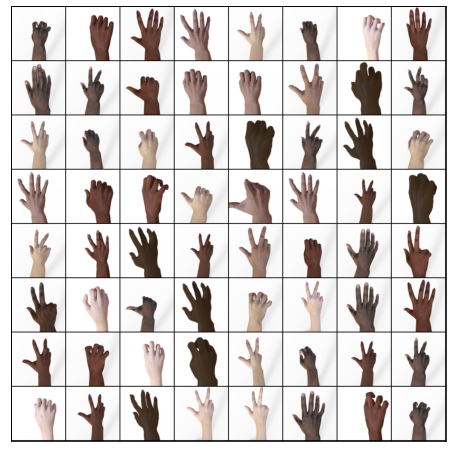

In [ ]:
show_batch(train_dl)

**Using a GPU**

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU, if one is available.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`).

In [ ]:
device = get_default_device()
device

device(type='cuda')

We can now move our training data loader using DeviceDataLoader for automatically transferring batches of data to the GPU (if available).

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

## **Conditional Generator Implementation**




In [ ]:
import torch.nn as nn

In [ ]:
z_dim = 100
n_classes = 3

Wed Jul 14 18:27:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    33W / 250W |    911MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class rpsdataset(Dataset):
    def __init__(self, root, transform):
        super().__init__()
        self.root = root
        self.files = [fname for fname in os.listdir(root) if fname.endswith('.jpg')]
        self.classes = list(set(parse_breed(fname) for fname in files))
        self.transform = transform
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        fpath = os.path.join(self.root, fname)
        img = self.transform(open_image(fpath))
        class_idx = self.classes.index(parse_breed(fname))
        return img, class_idx


The implementation of conditional generator consists of three models:

- The label_conditioned_generator takes the class label as input, feeds it to the embedding layer of 100 dimensions, followed by a dense or linear layer that has 16 neurons.
- The latent model has a dense layer with 4*4*512 neurons. These are fed noise or latent vector of 100 dimensions, followed by a LeakyRelu activation.
- The third model is fed a concatenated output ( [513, 4, 4] ) of the previous two models. It then outputs an image of size [3, 128, 128]

**Generator Initilization**

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Print the model
print(netG)

Generator(
  (label_conditioned_generator): Sequential(
    (0): Embedding(3, 100)
    (1): Linear(in_features=100, out_features=16, bias=True)
  )
  (latent): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(513, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_si

## **Conditional Discriminator Implementation**

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        self.ngpu = ngpu
        super(Discriminator, self).__init__()
        
    
        self.label_condition_disc = nn.Sequential(nn.Embedding(n_classes, latent_dim),
                                                  nn.Linear(latent_dim, 3*128*128))
             
        self.model = nn.Sequential(nn.Conv2d(6, 64, 4, 2, 1, bias=False),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Conv2d(64, 64*2, 4, 3, 2, bias=False),
                                   nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Conv2d(64*2, 64*4, 4, 3,2, bias=False),
                                   nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Conv2d(64*4, 64*8, 4, 3, 2, bias=False),
                                   nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                                   nn.LeakyReLU(0.2, inplace=True), 
                                   nn.Flatten(),
                                   nn.Dropout(0.4),
                                   nn.Linear(4608, 1),
                                   nn.Sigmoid()
                                   )

    def forward(self, inputs):
        img, label = inputs
        label_output = self.label_condition_disc(label)
        label_output = label_output.view(-1, 3, 128, 128)
        concat = torch.cat((img, label_output), dim=1)
        #print(concat.size())
        output = self.model(concat)
        return output

Like the generator in CGAN, even the conditional discriminator has two models: one to feed the labels, and the other for images.

- The label_condition_disc model is fed one of the three labels, which is mapped to embedding_dim=100. Followed by a linear layer, which maps the 100 dimension output from the previous layer to a dimension of 3*128*128. Why  should the linear layer  have 3*128*128 neurons? That’s simple.  We need to concatenate the label with the real or fake image, so the label feature has to match the image dimensions, i.e., 128*128.
- The model is fed a concatenation of the input image and output of the previous model ([6, 128, 128]), after which it outputs a single value that tells you whether the input image is real or fake.

**Discriminator Initilization**

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Print the model
print(netD)

Discriminator(
  (label_condition_disc): Sequential(
    (0): Embedding(3, 100)
    (1): Linear(in_features=100, out_features=49152, bias=True)
  )
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (6): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (9): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)


In [ ]:
# Loss functions
adversarial_loss = torch.nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
D_optimizer = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
G_optimizer = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [ ]:
import time
from tqdm.notebook import tqdm # Helper library shows a progress bar for each epoch
import torch.nn.functional as F

lr = 0.0002
num_epochs = 200

We can try out the generator function and see what kind of the images it is generating simply by first generating some of the latent tensors

## **Training the Conditional GAN**

Both loss function and optimizer are identical to our previous GAN posts, so let’s jump directly to the training part of CGAN, which again is almost similar, with few additions. We will only discuss the extensions in training, so if you haven’t read our earlier post on GAN, consider reading it for a better understanding.

In [ ]:
num_epochs = 200
for epoch in range(1, num_epochs+1): 

    D_loss_list, G_loss_list = [], []
   
    for index, (real_images, labels) in enumerate(train_loader):
        D_optimizer.zero_grad()
        real_images = real_images.to(device)
        labels = labels.to(device)
        labels = labels.unsqueeze(1).long()

      
        real_target = Variable(torch.ones(real_images.size(0), 1).to(device))
        fake_target = Variable(torch.zeros(real_images.size(0), 1).to(device))
      
        D_real_loss = discriminator_loss(discriminator((real_images, labels)), real_target)
        # print(discriminator(real_images))
        #D_real_loss.backward()
    
        noise_vector = torch.randn(real_images.size(0), latent_dim, device=device)  
        noise_vector = noise_vector.to(device)
        
       
        generated_image = generator((noise_vector, labels))
        output = discriminator((generated_image.detach(), labels))
        D_fake_loss = discriminator_loss(output,  fake_target)

    
        # train with fake
        #D_fake_loss.backward()
      
        D_total_loss = (D_real_loss + D_fake_loss) / 2
        D_loss_list.append(D_total_loss)
      
        D_total_loss.backward()
        D_optimizer.step()

        # Train generator with real labels
        G_optimizer.zero_grad()
        G_loss = generator_loss(discriminator((generated_image, labels)), real_target)
        G_loss_list.append(G_loss)

        G_loss.backward()
        G_optimizer.step()